# Small energy systems MILP example

__author__ = "Rahul Kakodkar"
__copyright__ = "Copyright 2023, Multi-parametric Optimization & Control Lab"
__credits__ = ["Rahul Kakodkar", "Efstratios N. Pistikopoulos"]
__license__ = "MIT"
__version__ = "1.0.0"
__maintainer__ = "Rahul Kakodkar"
__email__ = "cacodcar@tamu.edu"
__status__ = "Complete"


A simple problem with three processes

- Solar PV with varying capacity factor
- Wind Farm with varying capacity factor
- Lithium-ion battery storage

and varying demand.

The problem is modeled over two scales

- 0, network scale with 1 time period
- 1, scheduling and demand scales with 4 time periods



**Import modules**

In [356]:
import pandas 
from src.energiapy.components.temporal_scale import Temporal_scale
from src.energiapy.components.resource import Resource, VaryingResource
from src.energiapy.components.process import Process, ProcessMode, VaryingProcess
from src.energiapy.components.location import Location
from src.energiapy.components.scenario import Scenario
from src.energiapy.components.result import Result 
from src.energiapy.model.formulate import formulate, Constraints, Objective
from src.energiapy.plot import plot
from src.energiapy.model.solve import solve

**Input Data**

Factors are normalized, and can be used to account for:

- variable resource demand (demand_factor)
- intermittent resource availability (capacity factor)
- varying resource purchase cost (cost factor)

In [357]:
factors = pandas.read_excel('input.xlsx', sheet_name= 'Factors')
demand_factor = pandas.DataFrame(factors['Power'])
capacity_factor_pv = pandas.DataFrame(factors['PV'])
capacity_factor_wf = pandas.DataFrame(factors['WF'])


**Declare temporal scale**


Consider four seasons in a year.

Network decisions are taken annually (scale level 0)

Scheduling decisions are taken seasonally (scale level 1)


In [358]:
scales = Temporal_scale(discretization_list= [1, len(demand_factor)])

**Declare resources**

Resources can be declared with attributes such as maximum consumption (cons_max), resource price (price), maximum allowed inventory (store_max)

As also whether they can be discharged (sell), have to meet demand (demand)

In [359]:

resource_input = pandas.read_excel('input.xlsx', sheet_name= 'Resources')



In [360]:
resource_input

,name,cons_max,loss,revenue,price,store_max,store_min,sell,demand,basis,block,citation,varying,label,gwp
0,Solar,100,0,0,0,0,0,False,False,MW,a,a,NaN,SolAR Power,0
1,Wind,100,0,0,0,0,0,False,False,MW,a,a,NaN,Wind Power,0
2,Power,0,0,0,0,100,0,True,True,MW,a,a,NaN,Powr,0


In [361]:

resource_dict = {j: {i: resource_input[i][j] for i in resource_input.keys()} for j in range(len(resource_input['name']))}



In [362]:

resource_list = [Resource(name= resource_dict[i]['name'], cons_max= resource_dict[i]['cons_max'], loss = resource_dict[i]['loss'], \
    revenue = resource_dict[i]['revenue'], price = resource_dict[i]['price'], store_max = resource_dict[i]['store_max'], \
        store_min = resource_dict[i]['store_min'], sell = resource_dict[i]['sell'], demand = resource_dict[i]['demand'], \
            basis = resource_dict[i]['basis'], block = resource_dict[i]['block'], varying = resource_dict[i]['varying'], \
                label = resource_dict[i]['label'], gwp = resource_dict[i]['gwp']) for i in range(len(resource_input['name']))]

Solar = resource_list[0]
Wind = resource_list[1]
Power = resource_list[2]
Wind.varying = None
Solar.varying = None
Power.varying = VaryingResource.deterministic_price

**Declare processes**

Processes consume resources and can be of three type:

- storage, if storage = some_resource 
- single mode, as with the processes defined here wherein a conversions are provided
- multi mode, if a multiconversion dict is provided

In [363]:
LiI = Process(name='LiI', storage= Power, capex = 0, fopex=0 , vopex = 0,  prod_max=0, label='Lithium-ion battery', basis = 'MW')

WF = Process(name='WF', conversion={Wind: -1, Power: 1},capex=0, fopex=0, vopex=0, prod_max=0, label='Wind mill array', varying= VaryingProcess.deterministic_capacity, basis = 'MW')

PV = Process(name='PV', conversion={Solar: -1, Power: 1}, capex=0, fopex=0, vopex=0, prod_max=0, varying = VaryingProcess.deterministic_capacity, label = 'Solar PV', basis = 'MW')

In [364]:
process_input = pandas.read_excel('input.xlsx', sheet_name= 'Processes')
process_dict = {j: {i: process_input[i][j] for i in process_input.keys()} for j in range(len(process_input['name']))}


In [365]:
process_list = [LiI, WF, PV]

for i in range(3):
    process_list[i].capex = process_dict[i]['capex']
    process_list[i].vopex = process_dict[i]['vopex']
    process_list[i].fopex = process_dict[i]['fopex']
    process_list[i].prod_max = process_dict[i]['prod_max']
    

**Declare location**


Locations are essentially a set of processes, the required resources are collected implicitly.

Location-wise capacity, demand, and cost factors can be provided. 

The scales of the capacity and demand data need to be provided as well.

In [366]:
place = Location(name='place', processes= {LiI, PV, WF}, demand_factor = {Power: demand_factor}, capacity_factor= {PV: capacity_factor_pv, WF:capacity_factor_wf}, \
    capacity_scale_level= 1, demand_scale_level = 1, scales=scales, label='some place')

*plot varying factors*

Plotting functions in energiapy.plot can be used to plot the factors

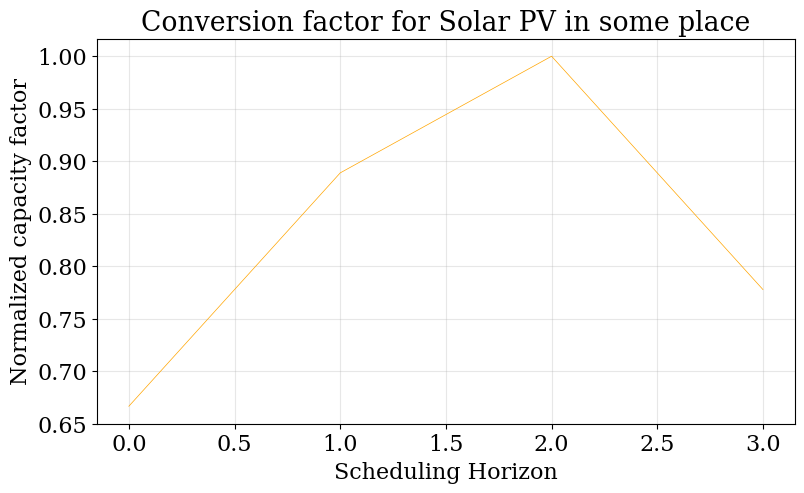

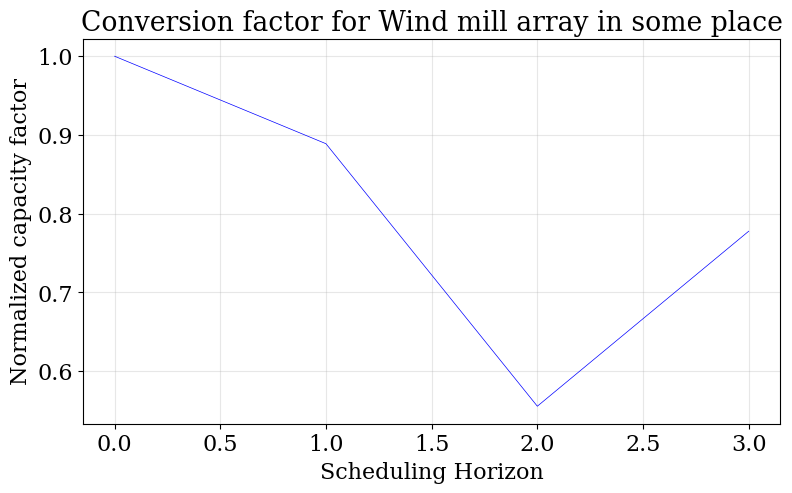

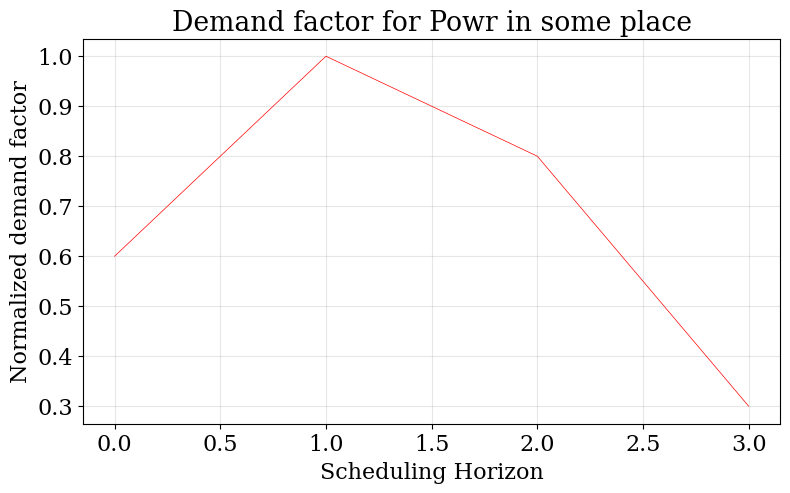

In [367]:
plot.capacity_factor(location= place, process= PV, fig_size= (9,5), color= 'orange')
plot.capacity_factor(location= place, process= WF, fig_size= (9,5), color= 'blue')
plot.demand_factor(location= place, resource= Power, fig_size= (9,5), color= 'red')

**Declare scenario**

The combination of parameter data, locations, and transportation options generates a scenario. 

Scenarios are data sets that can be fed to models for analysis. 

In this case we are generating a scenario for the location houston. The scales need to be consistent.

The demand, network, scheduling, and expenditure scales need to be provided. They all default to 0.

In [368]:
case = Scenario(name= 'case', network= place, network_scale_level= 0, demand_scale_level = 1, scheduling_scale_level= 1, scales= scales, label= 'small scenario')

**Formulate MILP**

Models can be formulated using different constraints and objectives.

milp is a pyomo instance, additional constraints can be provided in a bespoke manner

In [369]:
milp = formulate(scenario= case, demand = {place: {Power: 200}}, constraints={Constraints.cost, Constraints.inventory, Constraints.production, Constraints.resource_balance}, \
        objective= Objective.cost)

process capex constraint
process fopex constraint
process vopex constraint
process incidental constraint
location capex constraint
location fopex constraint
location vopex constraint
location incidental constraint
network capex constraint
network fopex constraint
network vopex constraint
network incidental constraint
nameplate inventory constraint
storage facility constraint
min storage facility constraint
nameplate production constraint
production facility constraint
min production facility constraint
inventory balance constraint at 0x000001B352BB37F0>
resource consumption constraint
resource purchase constraint
location production constraint
location discharge constraint
location consumption constraint
location purchase constraint
network production constraint
network discharge constraint
network consumption constraint
network purchase constraint
demand constraint
cost objective


**Solve**

To solve the model, the solve requires a scenario and a modeling instance to be provided. 

Also a solver needs to be chosen.

In [370]:
results = solve(scenario = case, instance= milp, solver= 'gurobi', name=f"MILP")

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 108 rows, 118 columns and 242 nonzeros
Model fingerprint: 0x39d31306
Variable types: 109 continuous, 9 integer (9 binary)
Coefficient statistics:
  Matrix range     [6e-01, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+01, 2e+02]
Presolve removed 108 rows and 118 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 265000 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.650000000000e+05, best bound 2.650000000000e+05, gap 0.0000%


**Results**

Models can be summarized as shown below:

In [371]:
results.model_summary()

SUMMARY:
            number of constraints: 108
            number of variables: 118
            number of binary variables: 9
            number of integer variables: 9
            number of continuous variables: 100


*Plot results*

Some handy plotting functions such as schedule can plot the production, consumption, sales, inventory schedules

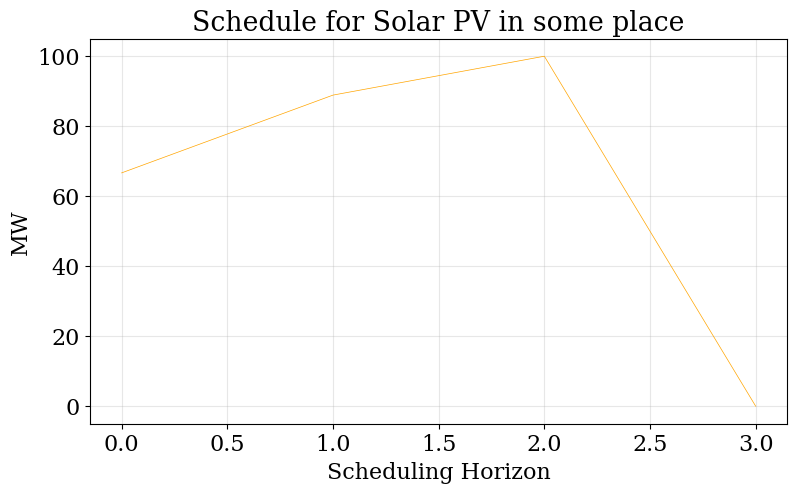

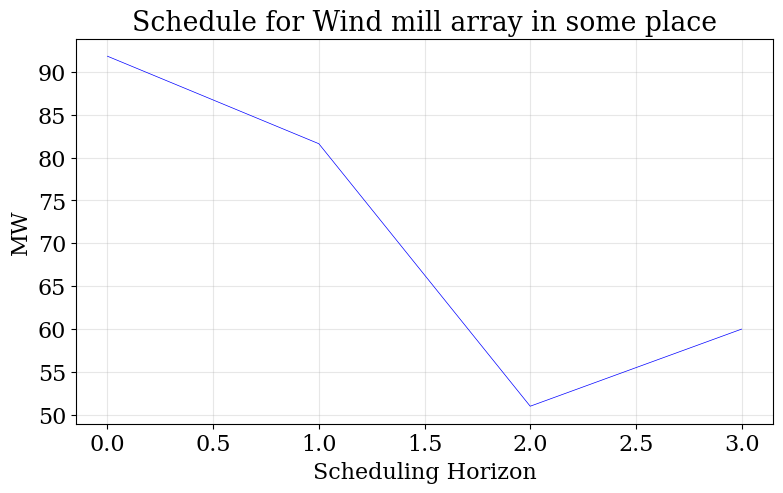

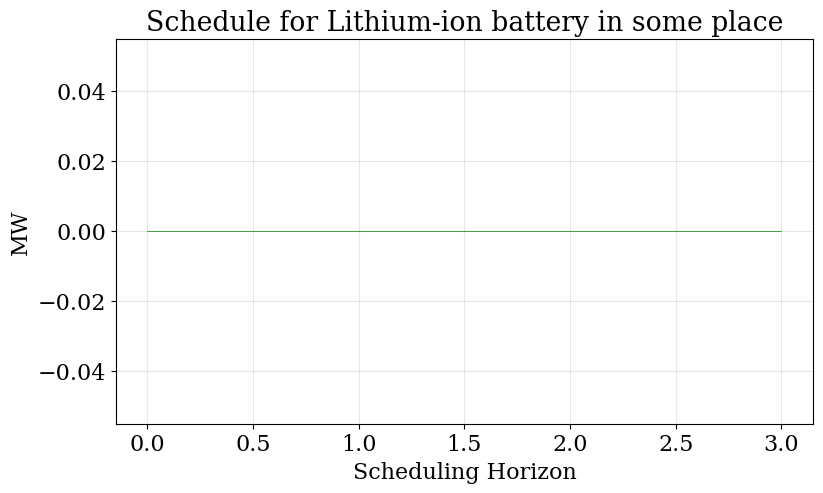

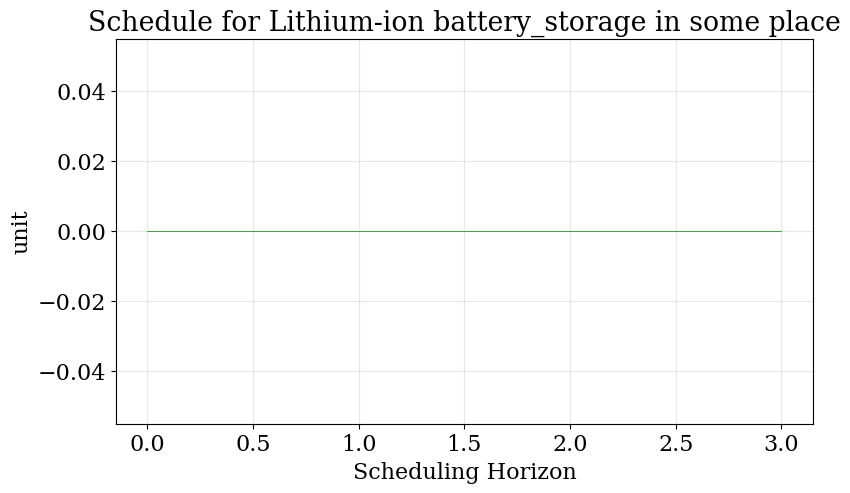

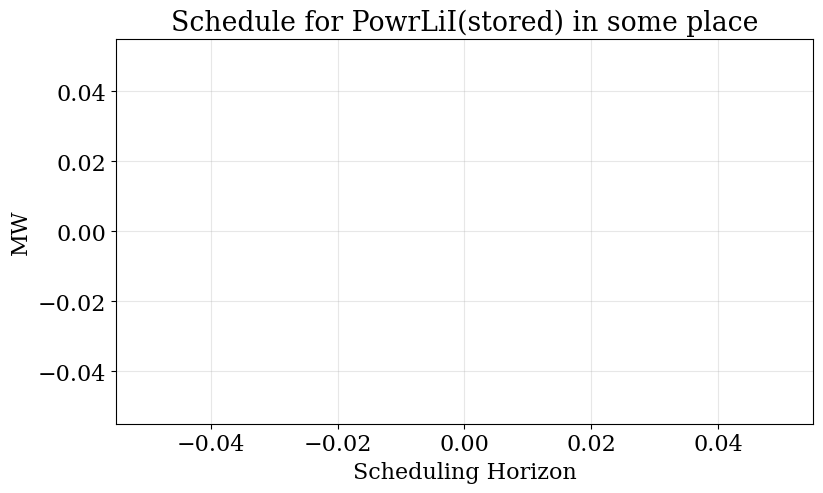

In [372]:
plot.schedule(results= results, y_axis= 'P', component= 'PV', location = 'place', fig_size= (9,5), color = 'orange')
plot.schedule(results= results, y_axis= 'P', component= 'WF', location = 'place', fig_size= (9,5), color = 'blue')
plot.schedule(results= results, y_axis= 'P', component= 'LiI', location = 'place', fig_size= (9,5), color = 'green')
plot.schedule(results= results, y_axis= 'P', component= 'LiI_discharge', location = 'place', fig_size= (9,5), color = 'green')
plot.schedule(results= results, y_axis= 'Inv', component= 'LiI_Power_stored', location = 'place', fig_size= (9,5), color = 'green')

All inputs are stored in results.component

All outputs are stored in results.output

Values can be accessed as shown below

In [373]:
results.output['X_P']

{('place', 'LiI', 0): 1.0,
 ('place', 'PV', 0): 1.0,
 ('place', 'LiI_discharge', 0): 1.0,
 ('place', 'WF', 0): 1.0}

In [374]:
results.output['Cap_P']

{('place', 'LiI', 0): 0.0,
 ('place', 'PV', 0): 100.0,
 ('place', 'LiI_discharge', 0): 100.0,
 ('place', 'WF', 0): 91.81818181818181}